
# Purpose

Understand the data, plot the thingies out and see what they look like. Maybe find some interesting things to know that I can use when I make the model

# What I want to do here

[x] Plot different structures. Plot from low size to high size and in between
[x] Plot every structure

[x] Different values in /nan/null/other in the data


[x] See the distribution of lengths of polymers
[x] See the distribution of different nucelotides
[x] See what distribution of nucleotides in what part of the string
[x] Most common k-length sequences

[x] See the distribution of distances between the different points
[x] See the distribution in change of angle between the different points


[x] Plot the densitities of the models


[x] Plot the cutoff dates


* Investigate the description, find common words, etc.



In [44]:
import general_utils
import utils

import time

import warnings
warnings.filterwarnings("ignore")

import os
import sys
import random
import pickle
import yaml

import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

start_time = time.time()

import GPUtil

GPUs = GPUtil.getGPUs()
if GPUs:
    gpu = GPUs[0]
    print(f"Running on: {gpu.name}")
else:
    print("Running on CPU")

Running on: NVIDIA A30


In [ ]:
def set_seed(seed: int):
    """Set a random seed for Python, NumPy, PyTorch (CPU & GPU) to ensure reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example configuration (you can load this from a YAML, JSON, etc.)
config = {
    "seed": 42,
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
    "max_len": 384,
    "batch_size": 1,

    "max_len_filter": 9999999,
    "min_len_filter": 10,
    
    # change to kaggle
    "train_sequences_path": "stanford-rna-3d-folding/train_sequences.csv",
    "train_labels_path": "stanford-rna-3d-folding/train_labels.csv",
    "test_sequences_path": "stanford-rna-3d-folding/test_sequences.csv",
}

# Set the seed for reproducibility
set_seed(config["seed"])

# Load data

In [ ]:
train_labels = pd.read_csv(config["train_labels_path"])

train_sequences = pd.read_csv(config["train_sequences_path"])

train_labels['target_id'] = train_labels['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])


# Plot structures

Plot from small to big and in between

In [ ]:

ranks_wanted = [1, 2, 5, 10, 25, 35, 50, 75, 90, 99, 100]
max_len = train_sequences['sequence'].apply(lambda x: len(x)).max()
ranks_wanted = [int(max_len * (rank / 100.)) for rank in ranks_wanted]

train_sequences['length'] = train_sequences['sequence'].apply(lambda x: len(x))
train_sequences['length_ranking'] = train_sequences['length'].rank()


for i, rank in enumerate(ranks_wanted):
    random_val = np.random.randint(1, 3)

    target_id = train_sequences.iloc[(train_sequences['length_ranking'] - rank).abs().argsort()[random_val - 1:random_val]]['target_id'].values[0]
    
    sequence = np.array(list(train_sequences[train_sequences['target_id'] == target_id]['sequence'].values[0]))

    x_1 = train_labels[train_labels['target_id'] == target_id]['x_1'].to_numpy()
    y_1 = train_labels[train_labels['target_id'] == target_id]['y_1'].to_numpy()
    z_1 = train_labels[train_labels['target_id'] == target_id]['z_1'].to_numpy()

    utils.plot_structure(
        sequences=sequence,
        x=x_1,
        y=y_1,
        z=z_1,
        name=target_id,
        size=3
    )

# Plot every RNA together

In [ ]:
all_ids = train_labels['target_id'].unique()

all_data_entries = []

for i, target_id in enumerate(all_ids):
    sequence = np.array(list(train_sequences[train_sequences['target_id'] == target_id]['sequence'].values[0]))

    x_1 = train_labels[train_labels['target_id'] == target_id]['x_1'].to_numpy()
    y_1 = train_labels[train_labels['target_id'] == target_id]['y_1'].to_numpy()
    z_1 = train_labels[train_labels['target_id'] == target_id]['z_1'].to_numpy()

    all_data_entries.append(
        {
            'name': target_id,
            'sequences': sequence,
            'x': x_1,
            'y': y_1,
            'z': z_1
        }
    )

utils.plot_multiple_structures(all_data_entries, size=2, linewidth=0.5)
    

# Explore null/nan

In [ ]:
null_rows_count = train_labels[['x_1', 'y_1', 'z_1']].isnull().any(axis=1).sum()
print(f"Number of rows with null values in coordinates: {null_rows_count}")
print(f"Percentage of rows with null values in coordinates: {null_rows_count / len(train_labels) * 100:.2f}%")


In [ ]:
nucleotides = set(''.join(train_sequences['sequence'].values))
print(f"Unique nucleotides in train_sequences: {nucleotides}")

print(f"Unique nucleotides in train_labels: {list(train_labels['resname'].unique())}")



In [ ]:
for nucleotide in nucleotides:
    print(f"Number of {nucleotide} in train_sequences: {train_sequences['sequence'].str.count(nucleotide).sum()}")

    print(f"Percentage of {nucleotide} in train_sequences: {train_sequences['sequence'].str.count(nucleotide).sum() / train_sequences['sequence'].apply(lambda x: len(x)).sum() * 100.:.2f}%")

    print(f"Number of null values in location with {nucleotide} nucleotide: {train_labels[train_labels['resname'] == nucleotide]['x_1'].isnull().sum()}\n")

# Plot distribution of xyz coords

In [ ]:
# Drop NaN values for x_1, y_1, and z_1
coordinates = ['x_1', 'y_1', 'z_1']
values = {coord: train_labels[coord].dropna() for coord in coordinates}

# Define bins for the ranges
bins = {coord: np.linspace(values[coord].min(), values[coord].max(), 20) for coord in coordinates}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot histograms
for i, coord in enumerate(coordinates):
    axes[i].hist(values[coord], bins=bins[coord], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Frequency of {coord} Ranges')
    axes[i].set_xlabel(f'{coord} Range')
    axes[i].set_ylabel('Frequency' if i == 0 else '')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()



# Distribution of RNA length

In [ ]:
train_sequences['sequence'].apply(lambda x: len(x)).plot.hist(
    bins=100,
    title='Length of Sequences Frequency Distribution',
    xlabel='Length',
    ylabel='Frequency',
    figsize=(10, 6),
    grid=True,
    color='blue',
    alpha=0.7
)

# What nucleotides in what segment of a string

In [ ]:
useful_nucleotides = ['A', 'C', 'G', 'U']

k=5 # number of parts to split the sequence into
ratios_dict = {}

for nucleotide in useful_nucleotides:
    for i in range(k):
        num_that = train_sequences['sequence'].apply(lambda x: x[int(i / k * len(x)):int((i + 1) / k * len(x))]).str.count(nucleotide)
        len_that = train_sequences['sequence'].apply(lambda x: len(x[int(i / k * len(x)):int((i + 1) / k * len(x))]))
        ratio = num_that / len_that
        key = f"{nucleotide}_{i + 1}"
        ratios_dict[key] = ratio.mean()
        print(f"Ratio of {nucleotide} in {i + 1}th part of sequence: {ratio.mean() * 100.:.2f}%")

ratios_df = pd.DataFrame(list(ratios_dict.items()), columns=['Segment', 'Mean Ratio'])


ratios_df[['Nucleotide', 'Part']] = ratios_df['Segment'].str.split('_', expand=True)
ratios_df['Part'] = ratios_df['Part'].astype(int)


plt.figure(figsize=(10, 6))
for nucleotide in useful_nucleotides:
    subset = ratios_df[ratios_df['Nucleotide'] == nucleotide]
    plt.plot(subset['Part'], subset['Mean Ratio'], marker='o', label=nucleotide)

plt.title('Mean Ratio of Nucleotides in Different Parts of Sequences')
plt.xlabel(f'Part of Sequence (split into {k} parts)')
plt.ylabel('Mean Ratio')
plt.legend(title='Nucleotide')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Find common k-length sequences

Uses sliding window on all sequences

In [ ]:
k = 5

all_sequences = train_sequences['sequence'].to_list()

k_sequences = {}

for sequence in all_sequences:
    for i in range(len(sequence) - k + 1):
        if sequence[i:i + k] in k_sequences.keys():
            k_sequences[sequence[i:i + k]] += 1
        else:
            k_sequences[sequence[i:i + k]] = 1

num_most_popular = 5

# get the ten most popular k-sequences
most_popular_k_sequences = sorted(k_sequences.items(), key=lambda x: x[1], reverse=True)[:num_most_popular]
print(f"The {num_most_popular} most popular {k} length k-sequences are: ", most_popular_k_sequences)

all_sequences_length = len(''.join(all_sequences))

for i in most_popular_k_sequences:
    print(f"Ratio of {i[0]} in all {k}-length sequences: {i[1] / all_sequences_length * 100.:.2f}%")



# Plot the distribution of distances between consecutive points for each dim

In [ ]:
all_distances = None

for id in all_ids:
    this_labels = train_labels[train_labels['target_id'] == id]
    
    distances = this_labels[['x_1', 'y_1', 'z_1']].dropna().to_numpy()
    distances = np.diff(distances, axis=0)

    if all_distances is None:
        all_distances = distances
    else:
        all_distances = np.vstack((all_distances, distances))

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i in range(3):
    axs[i].hist(distances[:, i], bins=50, edgecolor='black', alpha=0.7)
    axs[i].set_title('Distances')
    axs[i].set_xlabel('Distance')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot the distribution of change in angle between consecutive points

TODO Ensure correct

In [ ]:
def angle_change_3d(p1: np.array, p2: np.array, p3: np.array) -> float:
    """
    Computes change in angle from p1 to p2 vs p3 in 3d space
    """

    v1 = p2 - p1
    v2 = p3 - p2
    
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    
    if v1_norm == 0 or v2_norm == 0:
        raise ValueError("One of the vectors has zero length, cannot compute angle.")
    
    v1 = v1 / v1_norm
    v2 = v2 / v2_norm

    dot_product = np.clip(np.dot(v1, v2), -1.0, 1.0)
    
    return np.degrees(np.arccos(dot_product))

xyz_cats = ['x_1', 'y_1', 'z_1']

all_xyz = train_labels[xyz_cats].dropna().to_numpy()

print(all_xyz.shape)

differences = np.empty((all_xyz.shape[0] - 2, 3))

for i in range(len(all_xyz) - 2 - 1):
    differences[i, :] = angle_change_3d(all_xyz[i], all_xyz[i + 1], all_xyz[i + 2])


fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i in range(3):

    axs[i].hist(differences[:, i], bins=50, edgecolor='black', alpha=0.7)
    axs[i].set_title(f'{xyz_cats[i]}-axis Delta Angles')
    axs[i].set_xlabel('Angle (degrees)')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot the densities of different models

See if the small sequences are more dense than the big sequences

In [ ]:
sizes = []
densities = []
cutoff_threshold = 3 # If less than 3 points, ignore

for i, id in enumerate(all_ids):
    this_labels = train_labels[train_labels['target_id'] == id]

    all_points = this_labels[['x_1', 'y_1', 'z_1']].dropna().to_numpy()

    if all_points.shape[0] > cutoff_threshold:
        center_point = np.mean(all_points, axis=0)
        kde = gaussian_kde(all_points.T)

        sizes.append(all_points.shape[0])

        densities.append(kde(center_point))


plt.scatter(np.array(sizes), np.array(densities))
plt.title('Density vs. Sequence Size')
plt.xlabel('Sequence Size')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()


# Plot the temporal cutoff points

In [ ]:

date_nums = pd.to_datetime(train_sequences['temporal_cutoff']).map(pd.Timestamp.toordinal).values

fig, ax = plt.subplots(figsize=(8, 4))

ax.boxplot(date_nums, vert=False)

# Convert ordinal numbers back to readable dates for axis labels
ax.set_xticks(np.linspace(min(date_nums), max(date_nums), num=5))
ax.set_xticklabels(pd.to_datetime([pd.Timestamp.fromordinal(int(t)) for t in np.linspace(min(date_nums), max(date_nums), num=5)]).strftime('%Y-%m-%d'))

ax.set_title("Boxplot of Temporal cutoff Dates")
ax.set_xlabel("Date")
plt.show()

# Plot frequencies of different words in description

Actually, this was pretty useless

<Axes: >

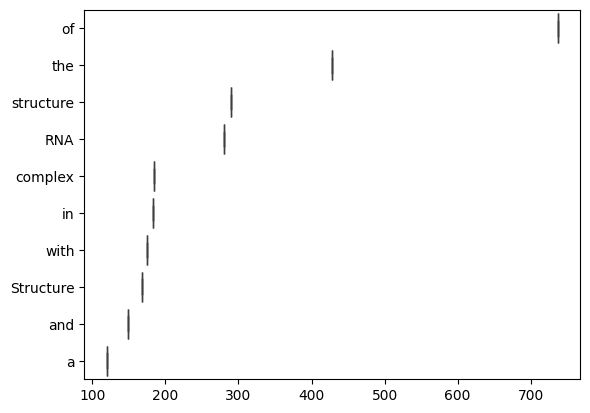

In [ ]:
from collections import Counter

num_top_words = 10

counters_found = Counter(' '.join(train_sequences['description'].astype(object).values).split(' '))

counters_found = dict(counters_found)

counters_found = {k: v for k, v in sorted(counters_found.items(), key=lambda item: item[1], reverse=True)}

sns.boxplot(y=list(counters_found.keys())[:num_top_words], x=list(counters_found.values())[:num_top_words])

In [ ]:
# See what chain is the mos tpopular. Chain A, Chain B, Chain C in all_structures string

In [ ]:
display(train_labels.head(3))
display(train_sequences.head(2))


# Explore Fasta files

In [ ]:
def display_fasta(file_path):
    """
    Displays the contents of a FASTA file.

    Args:
        file_path (str): The path to the FASTA file.
    """
    try:
        with open(file_path, 'r') as file:
            for line in file:
                print(line, end='')
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# file_path = 'sequence.fasta'
# display_fasta(file_path)

In [ ]:
file_path = f'stanford-rna-3d-folding/MSA/{sample_polymers[0]}.MSA.fasta'
display_fasta(file_path)

# Plotting